In [1]:
import os

# Use the current notebook directory as the root of the project
project_root = os.getcwd()
os.chdir(project_root)

print("Working directory set to:", os.getcwd())

Working directory set to: /Users/zhangjiuyue/jupternotebook/king's project


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Reading CSV questionnaire files
file_path = "./data/Evaluating AI-Generated Music.csv"
df = pd.read_csv(file_path)

# 2. Extract all columns containing ratings
rating_columns = [col for col in df.columns if "Please listen and rate the following" in col]

# 3. Construct a MOS table of 25 samples for every 5 columns (assuming a total of 5 sets of prompts)
num_prompts = len(rating_columns) // 25
num_samples = len(rating_columns) // 5

mos_data = {}
model_list = []

for i in range(num_samples):
    sample_name = f"sample_{i+1}"
    cols = rating_columns[i * 5:(i + 1) * 5]
    scores = df[cols].apply(pd.to_numeric, errors='coerce')
    means = scores.mean()
    dimensions = [col.split(":")[-1].strip().split(" (")[0] for col in cols]
    mos_data[sample_name] = dict(zip(dimensions, np.round(means, 2)))
    # Marker model source
    idx = i % 5
    if idx in [0, 1]:
        model_list.append("Udio")
    elif idx in [2, 3]:
        model_list.append("Mureka")
    elif idx == 4:
        model_list.append("Human")

mos_df = pd.DataFrame(mos_data).T
mos_df['Model'] = model_list
mos_df['Prompt'] = [f'Prompt_{i//5+1}' for i in range(num_samples)]
mos_df.to_csv("./outputs/mos_results.csv", index=False)

In [14]:
mos_df.rename(columns=lambda x: x.strip(" []"), inplace=True)

print(mos_df.columns.tolist())
# ['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment', 'Model', 'Prompt']

['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment', 'Model', 'Prompt']


## 📉Specific numerical results

In [15]:
# 4. Calculate the average score for each model under each Prompt
mos_grouped = mos_df.groupby(['Prompt', 'Model']).mean(numeric_only=True).reset_index()

# 5. Calculate the overall average score for each model
model_avg = mos_df.groupby('Model').mean(numeric_only=True)
print("Average global model score：\n", model_avg)

Average global model score：
         Naturalness  Stylistic Accuracy  Cultural Appropriateness  \
Model                                                               
Human         4.322               3.876                     4.072   
Mureka        3.428               3.546                     3.570   
Udio          3.080               3.030                     3.027   

        Originality  Overall Enjoyment  
Model                                   
Human         4.016              4.226  
Mureka        3.230              3.460  
Udio          3.170              2.957  


In [17]:
from scipy.stats import ttest_rel, ttest_ind

# For each Prompt, pair Udio with Mureka (paired t-test)
for dim in ['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment']:
    for prompt in mos_df['Prompt'].unique():
        udio = mos_df[(mos_df['Prompt'] == prompt) & (mos_df['Model'] == 'Udio')][dim]
        mureka = mos_df[(mos_df['Prompt'] == prompt) & (mos_df['Model'] == 'Mureka')][dim]
        if len(udio) == len(mureka):
            t_stat, p_val = ttest_rel(udio, mureka)
            print(f"{dim} ({prompt}): Udio vs Mureka, t={t_stat:.2f}, p={p_val:.4f}")

Naturalness (Prompt_1): Udio vs Mureka, t=-0.15, p=0.9059
Naturalness (Prompt_2): Udio vs Mureka, t=-1.71, p=0.3375
Naturalness (Prompt_3): Udio vs Mureka, t=-13.29, p=0.0478
Naturalness (Prompt_4): Udio vs Mureka, t=-21.86, p=0.0291
Naturalness (Prompt_5): Udio vs Mureka, t=-4.71, p=0.1331
Stylistic Accuracy (Prompt_1): Udio vs Mureka, t=-0.58, p=0.6638
Stylistic Accuracy (Prompt_2): Udio vs Mureka, t=-19.73, p=0.0322
Stylistic Accuracy (Prompt_3): Udio vs Mureka, t=-3.71, p=0.1678
Stylistic Accuracy (Prompt_4): Udio vs Mureka, t=-1.67, p=0.3440
Stylistic Accuracy (Prompt_5): Udio vs Mureka, t=-13.33, p=0.0477
Cultural Appropriateness (Prompt_1): Udio vs Mureka, t=-0.87, p=0.5459
Cultural Appropriateness (Prompt_2): Udio vs Mureka, t=-22.33, p=0.0285
Cultural Appropriateness (Prompt_3): Udio vs Mureka, t=-6.50, p=0.0972
Cultural Appropriateness (Prompt_4): Udio vs Mureka, t=-2.37, p=0.2539
Cultural Appropriateness (Prompt_5): Udio vs Mureka, t=-0.80, p=0.5704
Originality (Prompt_1): U

In [23]:
import numpy as np

mos_df['Sample'] = [i % 5 + 1 for i in range(len(mos_df))]

stability = {"Prompt": [], "Model": [], "Dimension": [], "AbsDiff": []}

dimensions = ['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment']
for prompt in mos_df['Prompt'].unique():
    for model, idxs in [('Udio', [1, 2]), ('Mureka', [3, 4])]:
        s1 = mos_df[(mos_df['Prompt'] == prompt) & (mos_df['Model'] == model) & (mos_df['Sample'] == idxs[0])]
        s2 = mos_df[(mos_df['Prompt'] == prompt) & (mos_df['Model'] == model) & (mos_df['Sample'] == idxs[1])]
        if not s1.empty and not s2.empty:
            for dim in dimensions:
                diff = abs(s1[dim].values[0] - s2[dim].values[0])
                stability["Prompt"].append(prompt)
                stability["Model"].append(model)
                stability["Dimension"].append(dim)
                stability["AbsDiff"].append(diff)

stab_df = pd.DataFrame(stability)
stab_summary = stab_df.groupby(['Model', 'Dimension'])['AbsDiff'].mean().unstack()
print("Model stability analysis (mean absolute divergence):\n", stab_summary.round(3))

Model stability analysis (mean absolute divergence):
 Dimension  Cultural Appropriateness  Naturalness  Originality  \
Model                                                           
Mureka                        0.260        0.168        0.112   
Udio                          0.266        0.132        0.140   

Dimension  Overall Enjoyment  Stylistic Accuracy  
Model                                             
Mureka                 0.092               0.252  
Udio                   0.130               0.248  


## 📊 Visualization of Results

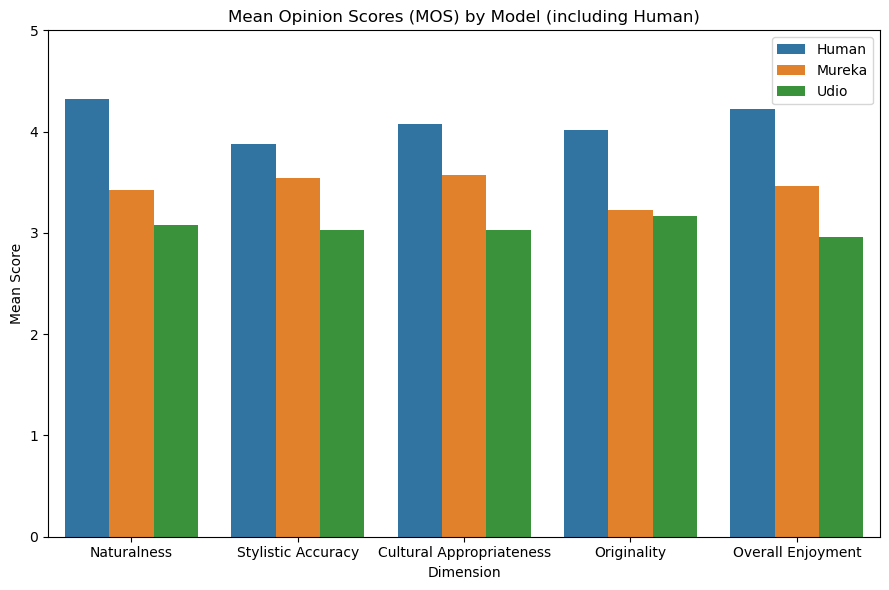

In [16]:
# 6. Drawing: average scores for each dimension of each model
import seaborn as sns

mos_long = model_avg.reset_index().melt(id_vars='Model', var_name='Dimension', value_name='Mean Score')
plt.figure(figsize=(9, 6))
sns.barplot(data=mos_long, x='Dimension', y='Mean Score', hue='Model')
plt.title('Mean Opinion Scores (MOS) by Model (including Human)')
plt.ylabel('Mean Score')
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mos_model_comparison.png"), dpi=300)
plt.show()

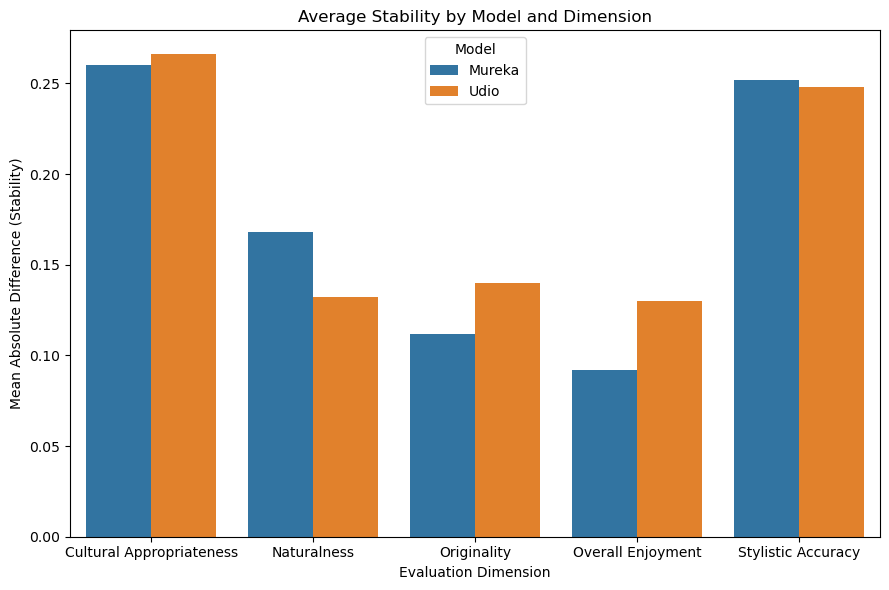

In [22]:
stab_summary = stab_df.groupby(['Model', 'Dimension'])['AbsDiff'].mean().reset_index()

plt.figure(figsize=(9, 6))
sns.barplot(data=stab_summary, x='Dimension', y='AbsDiff', hue='Model')
plt.ylabel('Mean Absolute Difference (Stability)')
plt.xlabel('Evaluation Dimension')
plt.title('Average Stability by Model and Dimension')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mcd_stability.png"), dpi=300)
plt.show()

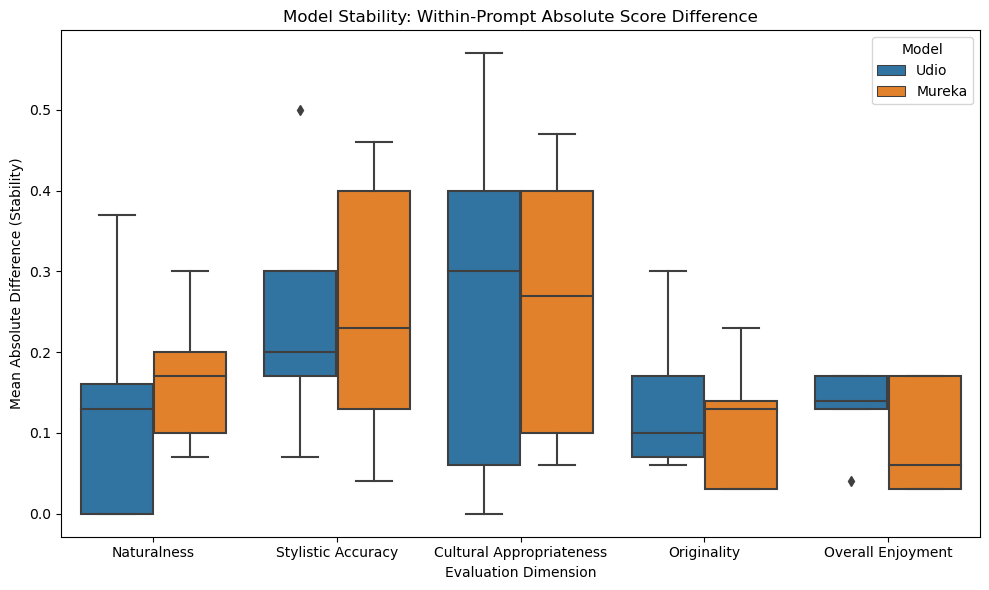

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=stab_df, x='Dimension', y='AbsDiff', hue='Model')
plt.ylabel('Mean Absolute Difference (Stability)')
plt.xlabel('Evaluation Dimension')
plt.title('Model Stability: Within-Prompt Absolute Score Difference')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mcd_stability2.png"), dpi=300)
plt.show()

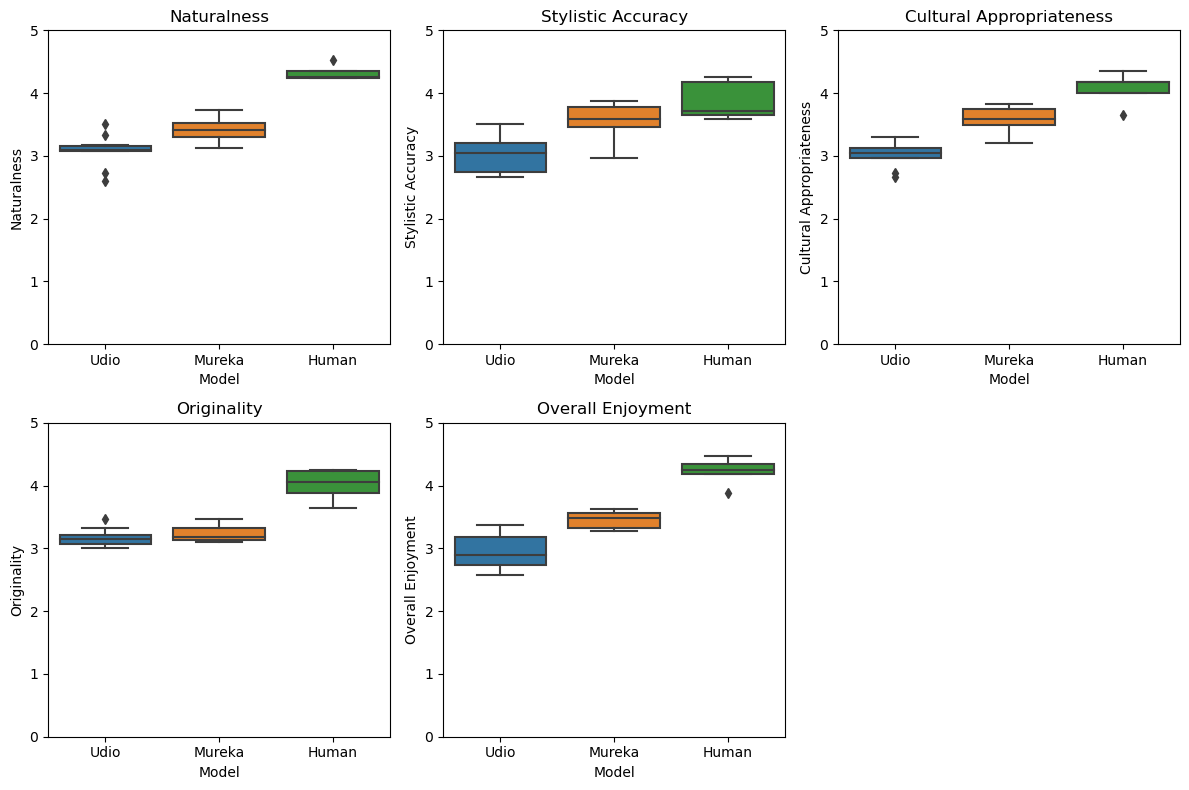

In [19]:
# Boxplot showing distribution
plt.figure(figsize=(12, 8))
for i, dim in enumerate(['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Model', y=dim, data=mos_df)
    plt.title(dim)
    plt.ylim(0, 5)
plt.tight_layout()
plt.show()

In [24]:
best_models = model_avg.idxmax()
print("Highest Score Models for Each Dimension：\n", best_models)

Highest Score Models for Each Dimension：
 Naturalness                 Human
Stylistic Accuracy          Human
Cultural Appropriateness    Human
Originality                 Human
Overall Enjoyment           Human
dtype: object


In [25]:
from scipy.stats import ttest_ind

for dim in dimensions:
    t_stat, p_val = ttest_ind(
        mos_df[mos_df['Model'] == 'Udio'][dim],
        mos_df[mos_df['Model'] == 'Mureka'][dim]
    )
    print(f"{dim} Udio vs Mureka: t={t_stat:.2f}, p={p_val:.4f}")

Naturalness Udio vs Mureka: t=-3.53, p=0.0024
Stylistic Accuracy Udio vs Mureka: t=-3.88, p=0.0011
Cultural Appropriateness Udio vs Mureka: t=-5.68, p=0.0000
Originality Udio vs Mureka: t=-1.01, p=0.3266
Overall Enjoyment Udio vs Mureka: t=-5.17, p=0.0001
